# Mutli Class Text Classification using a Transformer Decoder

In this notebook, we explore the task of **multiclass text classification** using the **20 Newsgroups** dataset, a well-known benchmark in the field of natural language processing (NLP). The dataset consists of approximately 20,000 newsgroup documents, distributed evenly across 20 different topics. Each document belongs to one of these topics, ranging from sports and politics to technology and religion, making it an ideal candidate for multiclass classification experiments.

The focus of this notebook is to implement and evaluate a **transformer-based** model, specifically designed to handle the complexities and nuances of natural language. By utilizing a transformer model, we aim to accurately classify texts into their respective newsgroup categories, leveraging the model's ability to understand and process text at a deep level. This approach highlights the capabilities of advanced NLP techniques in handling and categorizing large volumes of text data effectively.

In [1]:
#IMPORTS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud


2025-01-14 11:31:58.397834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-14 11:31:58.398001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-14 11:31:58.689226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## b) Exploratory data analysis (EDA)

In this section, we conduct Exploratory Data Analysis (EDA) to examine the distribution of data across the different newsgroups. Understanding the **distribution** is crucial as it can significantly influence the performance of our model. By analyzing how the data is spread among categories, we can identify any imbalances or peculiarities that might affect training and ultimately, the model's ability to **generalize** across unseen texts. This insight will guide us in making informed decisions during the model training process.

In this code snippet, we load the 20 Newsgroups dataset with only the essential text and labels by **excluding headers**, footers, and quotes to save storage space. We then create a DataFrame that maps numerical labels to their textual categories, focusing solely on the data needed for training our model.

In [2]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
#Create a DataFrame from the dataset
df = pd.DataFrame({'text': newsgroups.data, 'label': newsgroups.target})
#Map target labels to target names
df['label'] = df['label'].map(lambda x: newsgroups.target_names[x])

df.head()

,text,label
0,\n\nI am sure some bashers of Pens fans are pr...,rec.sport.hockey
1,My brother is in the market for a high-perform...,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,comp.sys.mac.hardware


In [3]:
df.describe()

,text,label
count,18846,18846
unique,18287,20
top,,rec.sport.hockey
freq,380,999


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18846 non-null  object
 1   label   18846 non-null  object
dtypes: object(2)
memory usage: 294.6+ KB


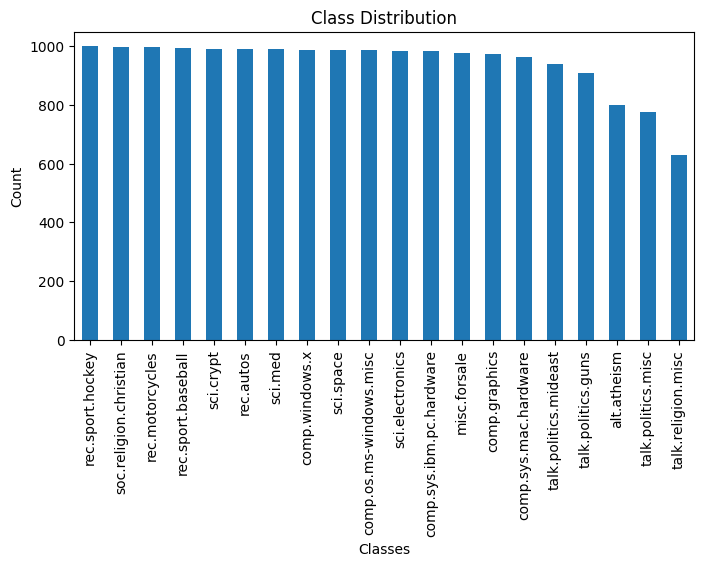

In [5]:
plt.figure(figsize=(8, 4))
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

The bar chart displays the **class distribution** of documents in the 20 Newsgroups dataset. Each bar represents one of the newsgroups, with categories ranging from sports like hockey and baseball to various topics in technology and religion. Most categories have a fairly uniform distribution, hovering **around 800 to 1000 documents** each. However, a few categories, such as **'talk.politics.mideast'** and **'talk.religion.misc'**, show slightly lower counts, which might affect model training by introducing some degree of **class imbalance**. This distribution is important for understanding how well the model might perform across different classes and whether any adjustments are needed to handle less represented classes effectively.

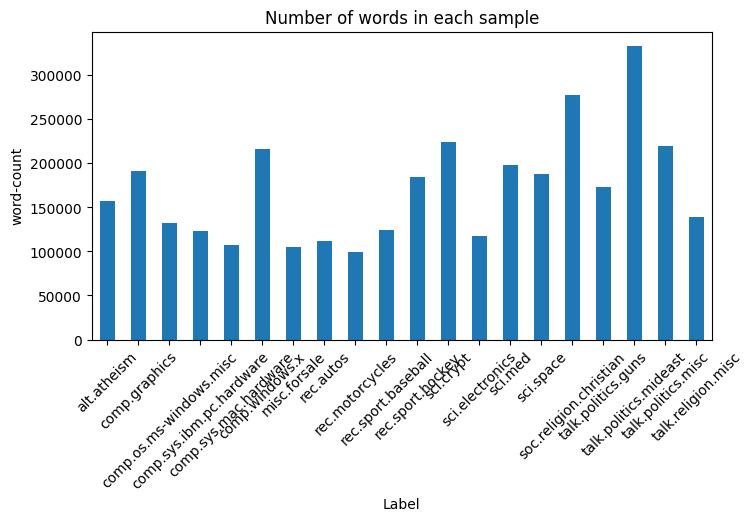

In [6]:
df['word_count'] = df['text'].apply(lambda text : len(text.split()))
total_word_count_by_target = df.groupby('label')['word_count'].sum()
plt.figure(figsize=(8, 4))
total_word_count_by_target.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('word-count')
plt.title('Number of words in each sample')
plt.xticks(rotation=45)
plt.show()

This bar chart illustrates the **total number of words for each category** in the 20 Newsgroups dataset. Notably, there are significant variations in the word count among different newsgroups, which suggests a disparity in content density and verbosity across topics. For example, newsgroups related to technology and politics, such as **'comp.sys.ibm.pc.hardware'**, **'rec.autos'**, and **'talk.politics.mideast'**, show a higher total word count, which might indicate **more detailed discussions** within these categories.

Comparing this with the previous plot showing the class distribution, we see that while some categories like **'talk.politics.mideast'** have fewer documents, the word count per document tends to be higher, suggesting more in-depth discussions within these fewer documents. On the other hand, categories with a high number of documents, such as 'rec.sport.hockey', might have shorter, more concise posts. This variance in document length and verbosity across categories can impact the model training.

Next, we visualize word clouds for the newsgroups with the highest and lowest document counts to highlight the most frequent words in each category. This comparison helps us understand thematic differences and potential biases in the dataset, providing insights into how these might influence model training.

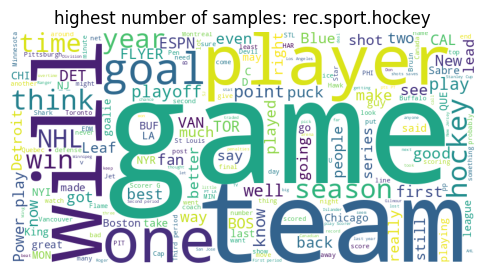

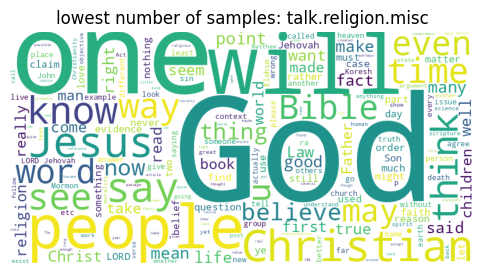

In [7]:
class_counts = df['label'].value_counts()

#Get texts of wanted labels.
highest = df[df['label'] == class_counts.idxmax()]['text']
lowest = df[df['label'] == class_counts.idxmin()]['text']

wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate(' '.join(highest))
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud_high)
plt.title(f'highest number of samples: {class_counts.idxmax()}')
plt.axis('off')
plt.show()

wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate(' '.join(lowest))
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud_low)
plt.title(f'lowest number of samples: {class_counts.idxmin()}')
plt.axis('off')
plt.show()

The word clouds generated for the newsgroups with the highest and lowest number of samples, rec.sport.hockey and talk.religion.misc respectively, illustrate distinct thematic content. In the **rec.sport.hockey** word cloud, terms like **"NHL", "season", "play"**, and specific team names like **"Boston", "Leaf", and "NYI"** dominate, reflecting the sports-related discussions typical of this group. Conversely, the **talk.religion.misc** word cloud features words like **"God", "Christian", "Bible", and "faith"**, indicating a focus on religious topics and discussions. These visualizations highlight the specific language and topics prevalent in each group, underlining the thematic uniqueness of the dataset's categories.

## A. Data Preprocessing
Let's split the data, to later see how the model performs on unseen data and if any overfitting can be observed.

In [8]:
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=27)
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=27)

x_train, y_train = newsgroups_train.data, newsgroups_train.target
x_test, y_test = newsgroups_test.data, newsgroups_test.target

In this step, I tokenize the data without removing stopwords or performing other preprocessing tasks. I anticipate that the transformer model is robust enough to manage the full complexity of the data, including common and less informative words.

In [9]:
#How many words to use. I would like to use more,
#But colab does not provide more memory.
vocab_size = 30000

#transform text to numerical values.
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

#Length of longest article. Also used for padding.
#Here i divide by 20, because otherwise the model would run out of memory :(.
maxlen = max([len(x) for x in x_train_seq] + [len(x) for x in x_test_seq]) // 20
print(maxlen)

#Here use the in the up calculated maxlen
x_train = pad_sequences(x_train_seq, maxlen=maxlen)
x_test = pad_sequences(x_test_seq, maxlen=maxlen)

1381


The "maxlen" variable is used to pad the sentences, before inserting them in the model to train. This is necessary, because the model expects all samples to have the same length.

## d) Model Training

https://www.datacamp.com/tutorial/how-transformers-work

The provided code defines two key components essential for building a Transformer model for text processing:

***TransformerBlock:*** This class encapsulates the core functionality of a Transformer, including:

**MultiHeadAttention:** Allows the model to simultaneously attend to different subsections of the input sequence, capturing various context details.

**Feed-Forward Network:** Processes the information post-attention with two dense layers.

**LayerNormalization and Dropout:** These are used to stabilize the learning process and reduce overfitting by normalizing the outputs of the layers and randomly omitting some of the layer outputs during training, respectively.

In [10]:
#Here the Transformer is defined. Usage of dropout and layernormalization to avoid overfitting.
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

***TokenAndPositionEmbedding:*** Manages embeddings for both tokens and their positions within sequences, essential for the model to understand word meanings and their sequential context. This class combines token vectors with position vectors to fully integrate semantic and positional information into the model's inputs.

In [11]:
#Embeddings of the words.
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

The specified configurations—embedding dimension of 128, 8 attention heads, and a feed-forward network dimension of 64—represent the optimal settings that yielded the best results for this model.

Despite the transformer block, we make use of the following layer:
**Global Average Pooling:** This layer aggregates the features extracted by the Transformer across the sequence dimension, calculating the average of each feature across all time steps. This operation condenses the data into a fixed-size output, which helps in reducing the model's complexity and improving its generalizability by minimizing overfitting. This technique is particularly effective in text processing, where it aids in summarizing the overall contextual information from the input sequence.

In [12]:
#-------------------Model Architecture-------------------
embed_dim = 128  #embedding size
num_heads = 8
ff_dim = 64  #count of neurons in ff layer inside of the transformer.

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training = True)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)#High dropout, but my model tends to overfit quickly.
outputs = Dense(20, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [13]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train,
                    batch_size=64, epochs=10,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/10


W0000 00:00:1736854384.512986     122 hlo_rematerialization.cc:2946] Can't reduce memory use below 11.15GiB (11977157725 bytes) by rematerialization; only reduced to 11.73GiB (12596259136 bytes), down from 11.76GiB (12630149552 bytes) originally
I0000 00:00:1736854386.903938     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1736854386.917493     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.0680 - loss: 3.3392

W0000 00:00:1736854545.099500     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/177 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.0688 - loss: 3.3349 - val_accuracy: 0.5424 - val_loss: 1.5715
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.7189 - loss: 0.9630 - val_accuracy: 0.8216 - val_loss: 0.6146
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9621 - loss: 0.1465 - val_accuracy: 0.8356 - val_loss: 0.6829
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9904 - loss: 0.0426 - val_accuracy: 0.8363 - val_loss: 0.7368
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9967 - loss: 0.0174 - val_accuracy: 0.8384 - val_loss: 0.7496
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9995 - loss: 0.0068 - val_accuracy: 0.8386 - val_loss: 0.8135
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9993 - loss: 0.0048 - val_accuracy: 0.8338 - val_loss: 0.8443
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9992 - loss: 0.0052 - val_accuracy: 0.837

## Model evaluation

In [14]:
from sklearn.metrics import classification_report

results = model.evaluate(x_test, y_test, verbose=1)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

y_pred_prob = model.predict(x_test, batch_size=64, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(20)])
print(report)


236/236 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.8296 - loss: 0.9506


W0000 00:00:1736856288.689067     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


loss: 0.927
compile_metrics: 0.832
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 300ms/step
              precision    recall  f1-score   support

     Class 0       0.79      0.76      0.77       319
     Class 1       0.79      0.75      0.77       389
     Class 2       0.61      0.78      0.69       394
     Class 3       0.69      0.72      0.71       392
     Class 4       0.89      0.77      0.83       385
     Class 5       0.90      0.75      0.82       395
     Class 6       0.74      0.86      0.80       390
     Class 7       0.89      0.88      0.88       396
     Class 8       0.90      0.96      0.93       398
     Class 9       0.96      0.95      0.95       397
    Class 10       0.97      0.97      0.97       399
    Class 11       0.92      0.94      0.93       396
    Class 12       0.82      0.68      0.74       393
    Class 13       0.89      0.84      0.86       396
    Class 14       0.85      0.94      0.89       394
    Class 15       0.89      0.92      0.90       398
  

The **classification report** reveals variations in model performance across different categories, influenced significantly by the number and **length of samples** in each class. Higher performance metrics in classes like 9, 10, and 11 correlate with adequate sample sizes and distinct content features, facilitating effective learning. Conversely, classes with fewer or less distinctive samples, such as 18 and 19, show lower precision and recall, indicating challenges in accurately classifying these groups. Overall, the model achieves an average accuracy of 83%, suggesting a generally robust ability to handle diverse categories, though improvements could be targeted towards classes with fewer or more complex samples to enhance overall performance.

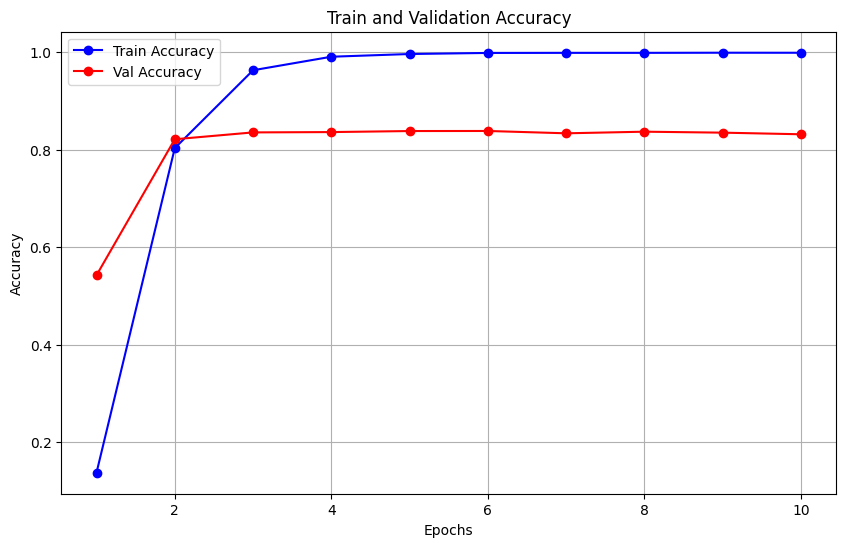

In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Val Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

The plot shows the training and validation accuracy of a model over 10 epochs. Initially, both accuracies increase sharply, demonstrating **rapid learning** within the first few epochs. By the third epoch, training accuracy levels off near perfect performance, while validation accuracy **stabilizes at around 0.85**. This indicates that while the model is highly effective on the training data, it doesn’t generalize quite as well to unseen data. The consistent gap between the training and validation accuracies suggests potential overfitting, where the model memorizes training details but struggles to apply its learning more broadly. To enhance its performance on new data, strategies to reduce this gap and improve generalization would be beneficial.